# Evaluate the Harmony question matcher using the existing McElroy et al harmonisation tool as a gold standard

This is a validation of Harmony against the questionnaire harmonisation tool developed by McElroy et al in 2020.

You can read in detail about the validation report here:

https://harmonydata.org/measuring-the-performance-of-nlp-algorithms/

You can read an explanation of the technologies evaluated here:

https://harmonydata.org/how-does-harmony-work/

In [1]:
MODEL_NAME = "Model 2: Tf*Idf with EN/PT dictionary lookup and no stopwords"

import sys
sys.path.append("../front_end")
from utils.question_matcher_nonpretrained import QuestionMatcherNonpretrained
qm = QuestionMatcherNonpretrained(stops = [])
match_function = lambda question_dfs : qm.match_questions(question_dfs)

In [2]:
from IPython.display import display, HTML
import bz2
import os
import pickle as pkl
import re
import sys
from nltk.corpus import stopwords
from langdetect import detect
import numpy as np
import operator 
import pandas as pd
import sklearn.metrics as metrics
import matplotlib.pyplot as plt

from utils.spacy_wrapper import get_spacy_model

pd.set_option("max_colwidth", None)
pd.set_option("max_seq_items", None)

In [3]:
INPUT_FILE = "../data/Final harmonised item tool EM.xlsx"


In [4]:
def normalise_question(original_text: str):
    """
    Checks if two questions have identical text.
    This is because they are by definition equivalent even if they are in different columns in the harmonisation tool by McElroy et al.
    """
    return re.sub(r'\W', '', original_text.lower())

In [5]:
validation_data = {}

for sheet_name in ("Childhood","Adulthood"):

    df = pd.read_excel(INPUT_FILE, sheet_name=sheet_name)

    if sheet_name == "Adulthood":
        labels_in_this_sheet = ["Adulthood"] * len(df)
        df = df[df.columns[4:]]
    else:
        labels_in_this_sheet = list(df["Developmental period"])
        df = df[df.columns[5:]]

    all_questions = []
    category_to_id = {}
    for idx in range(0, len(df)):
        questions_in_survey = []
        for column in df.columns:
            cell_content = df[column].iloc[idx]
            if type(cell_content) is str:
                for text in cell_content.split("/"):
                    text = re.sub(r'[^A-Za-z -,]', '', text.strip()).strip()
                    category = column.strip()
                    if category not in category_to_id:
                        category_to_id[category] = len(category_to_id)
                    category_id = category_to_id[category]
                    if len(text) > 2:
                        
                        questions_in_survey.append((text, category_id, normalise_question(text)))
        all_questions.append(questions_in_survey)
    
    validation_data[sheet_name] = all_questions

In [6]:
validation_data["GAD-7"] = [[], []]
for en, pt in zip("""Feeling nervous, anxious, or on edge
Not being able to stop or control worrying
Worrying too much about different things
Trouble relaxing
Being so restless that it is hard to sit still
Becoming easily annoyed or irritable
Feeling afraid, as if something awful might happen""".split("\n"),
"""Sentir-se nervoso/a, ansioso/a ou muito tenso/a
Não ser capaz de impedir ou de controlar as preocupações
Preocupar-se muito com diversas coisas
Dificuldade para relaxar
Ficar tão agitado/a que se torna difícil permanecer sentado/a
Ficar facilmente aborrecido/a ou irritado/a
Sentir medo como se algo horrível fosse acontecer""".split("\n")
                 ):
    validation_data["GAD-7"][0].append((en, en, normalise_question(en)))
    validation_data["GAD-7"][1].append((pt, en, normalise_question(pt)))

Validating on dataset Childhood
	Processing 47 instruments of average length 23 questions each
	Calculated 562315 match scores
	Generated 40708 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES Childhood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Is Irritable,She reacts intensely when upset,0.0,1
1,Stares into Space,When she moves about she tends to move slowly,0.0,1
2,Cries Easily,She tends to be somewhat emotional,0.0,1
3,Other Children Dislike Child,She makes friends easily,0.0,1
4,Other Children Dislike Child,She is very sociable,0.0,1
5,Other Children Dislike Child,She is very friendly with strangers,0.0,1
6,Does things on Own,She makes friends easily,0.0,1
7,Does things on Own,She is very sociable,0.0,1
8,Does things on Own,She is very friendly with strangers,0.0,1
9,Gets on With Other Children,She makes friends easily,0.0,1



FALSE POSITIVES OR WEAKEST REJECTIONS Childhood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Has Stutter or Stammer,Has a stutter or stammer,1.00,0
1,Cannot settle to anything for more than a few moments,Child cannot settle to do anything for more than a few moments,0.96,0
2,Child cannot settle to do anything for more than a few moments,Has difficulty in settling to anything for more than a few moments,0.78,0
3,Bullies Other Children,Is bullied by other children,0.77,0
4,Gets on With Other Children,Gets on better with adults than with other children,0.75,0
5,Child bullies other children,Is bullied by other children,0.73,0
6,sometimes restless in class,sometimes daydreams in class,0.72,0
7,"usually gloomy and sad"" or ""Normal attitude to criticism and punishment","frequently disobedient"" or ""Normal attitude to criticism and punishment",0.70,0
8,"A quarrelsome and aggressive child"" or ""Takes a normal part in rough games","very anxious"" or ""Takes a normal part in rough games",0.69,0
9,"""Normally energetic","frequently restless in class"" or ""Normally energetic",0.67,0


Validating on dataset Adulthood
	Processing 28 instruments of average length 16 questions each
	Calculated 96017 match scores
	Generated 9580 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES Adulthood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Have you felt downhearted and low,I laughed a lot,0.0,1
1,Have you felt downhearted and low,I cried a lot,0.0,1
2,Have you been a happy person,I felt miserable or unhappy,0.0,1
3,Have you been a happy person,I laughed a lot,0.0,1
4,Have you been a happy person,I cried a lot,0.0,1
5,Have you felt so down in the dumps that nothing could cheer you up,I didnt enjoy anything at all,0.0,1
6,Have you felt so down in the dumps that nothing could cheer you up,Been able to enjoy your normal daytoday activites,0.0,1
7,Did you feel tired,exhaustion),0.0,1
8,Did you feel full of life,exhaustion),0.0,1
9,Did you have a lot of energy,exhaustion),0.0,1



FALSE POSITIVES OR WEAKEST REJECTIONS Adulthood



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Do you suddenly become scared for no good reason,Been getting scared or panicky for no good reason,0.61,0
1,Do you often suddenly become scared for no good reason,Been getting scared or panicky for no good reason,0.59,0
2,Have you felt so down in the dumps that nothing could cheer you up,"During the last days, about how often did you feel so depressed nothing could cheer you up",0.54,0
3,Did you feel worn out,Do you wear yourself out worrying about your health,0.51,0
4,Have you been a happy person,Have you been a very nervous person,0.51,0
5,Did you feel worn out,Does every little thing get on your nerves and wear you out,0.45,0
6,Have you been a happy person,I felt I was a bad person,0.45,0
7,Felt that life is entirely hopeless,Felt that life isn't worth living,0.45,0
8,Been getting a feeling of tightness or pressure in your head,Been getting any pains in your head,0.44,0
9,Have you been a very nervous person,I was very restless,0.41,0


Validating on dataset GAD-7
Found GAD-7 Portuguese
	Processing 2 instruments of average length 7 questions each
	Calculated 49 match scores
	Generated 49 gold-standard values to compare them to
	Calculating ROC curve

FALSE NEGATIVES OR WEAKEST MATCHES GAD-7



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Worrying too much about different things,Preocupar-se muito com diversas coisas,0.14,1
1,Becoming easily annoyed or irritable,Ficar facilmente aborrecido/a ou irritado/a,0.23,1
2,"Feeling nervous, anxious, or on edge","Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.28,1
3,Not being able to stop or control worrying,Não ser capaz de impedir ou de controlar as preocupações,0.29,1
4,Being so restless that it is hard to sit still,Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.34,1
5,Trouble relaxing,Dificuldade para relaxar,0.34,1
6,"Feeling afraid, as if something awful might happen",Sentir medo como se algo horrível fosse acontecer,0.42,1



FALSE POSITIVES OR WEAKEST REJECTIONS GAD-7



,Instrument 1,Instrument 2,Score from model,Ground truth
0,Not being able to stop or control worrying,Ficar facilmente aborrecido/a ou irritado/a,0.12,0
1,"Feeling nervous, anxious, or on edge",Sentir medo como se algo horrível fosse acontecer,0.11,0
2,Being so restless that it is hard to sit still,Ficar facilmente aborrecido/a ou irritado/a,0.10,0
3,Being so restless that it is hard to sit still,Sentir medo como se algo horrível fosse acontecer,0.10,0
4,Being so restless that it is hard to sit still,Não ser capaz de impedir ou de controlar as preocupações,0.08,0
5,"Feeling afraid, as if something awful might happen",Ficar tão agitado/a que se torna difícil permanecer sentado/a,0.08,0
6,"Feeling nervous, anxious, or on edge",Ficar facilmente aborrecido/a ou irritado/a,0.07,0
7,Not being able to stop or control worrying,Sentir medo como se algo horrível fosse acontecer,0.06,0
8,Becoming easily annoyed or irritable,Não ser capaz de impedir ou de controlar as preocupações,0.05,0
9,Becoming easily annoyed or irritable,"Sentir-se nervoso/a, ansioso/a ou muito tenso/a",0.05,0


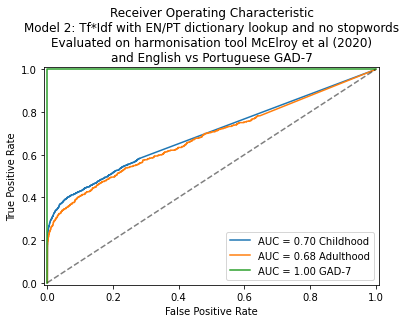

In [7]:
for dataset, dataset_data in validation_data.items():
    print (f"Validating on dataset {dataset}")
    question_dfs = []
    for questionnaire in dataset_data:
        df = pd.DataFrame({"question": [q for q, c, n in questionnaire]})
        df.attrs['language'] = "en"
        if dataset == "GAD-7" and "Sentir" in questionnaire[0][0]:
            df.attrs['language'] = "pt"
            print ("Found GAD-7 Portuguese")
        question_dfs.append(df)
    
    print (f"\tProcessing {len(question_dfs)} instruments of average length {int(np.round(np.mean([len(d) for d in question_dfs])))} questions each")
    matches = match_function(question_dfs)
    
    print (f"\tCalculated {len(matches)} match scores")
    
    pairs_already_seen = set()
    gold_standard = {}
    for i in range(len(dataset_data)):
        for j in range(i + 1, len(dataset_data)):
            for ii in range(len(dataset_data[i])):
                for jj in range(len(dataset_data[j])):
                    tup = tuple(sorted([dataset_data[i][ii][2], dataset_data[j][jj][2]]))
                    if tup not in pairs_already_seen:
                        gold_standard[(i, ii, j, jj)] = int(
                            (dataset_data[i][ii][1] == dataset_data[j][jj][1])
                            or 
                            (dataset_data[i][ii][2] == dataset_data[j][jj][2])
                        )
                    pairs_already_seen.add(tup)
    
    print (f"\tGenerated {len(gold_standard)} gold-standard values to compare them to")
    
    print ("\tCalculating ROC curve")
    
    y_pred = []
    y_test = []
    for m, g in gold_standard.items():
        y_pred.append(abs(matches.get(m, 0)))
        y_test.append(g)

    fpr, tpr, threshold = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    plt.plot(fpr, tpr, label = f'AUC = {roc_auc:0.2f} {dataset}')
    
    print (f"\nFALSE NEGATIVES OR WEAKEST MATCHES {dataset}\n")

    all_positives = [m for m in gold_standard if gold_standard[m] == 1 ]
    estimated_values_for_gt_1 = dict([(m,abs(matches[m])) for m in all_positives ])

    ctr = 0    
    examples = []
    for match_tuple, score_from_model in sorted(estimated_values_for_gt_1.items(), key=operator.itemgetter(1)):
        examples.append((question_dfs[match_tuple[0]].question.iloc[match_tuple[1]], question_dfs[match_tuple[2]].question.iloc[match_tuple[3]], np.round(score_from_model, 2)))

        ctr += 1
        if ctr > 10:
            break
    df_examples = pd.DataFrame({"Instrument 1":[e[0] for e in examples],"Instrument 2":[e[1] for e in examples],"Score from model":[e[2] for e in examples]})
    df_examples["Ground truth"] = 1
    display(df_examples)
    

    print (f"\nFALSE POSITIVES OR WEAKEST REJECTIONS {dataset}\n")

    all_negatives = [m for m in gold_standard if gold_standard[m] == 0 ]
    estimated_values_for_gt_1 = dict([(m,abs(matches[m])) for m in all_negatives ])

    ctr = 0
    examples = []
    for match_tuple, score_from_model in sorted(estimated_values_for_gt_1.items(), key=operator.itemgetter(1), reverse=True):
        examples.append((question_dfs[match_tuple[0]].question.iloc[match_tuple[1]], question_dfs[match_tuple[2]].question.iloc[match_tuple[3]], np.round(score_from_model, 2)))

        ctr += 1
        if ctr > 10:
            break
    df_examples = pd.DataFrame({"Instrument 1":[e[0] for e in examples],"Instrument 2":[e[1] for e in examples],"Score from model":[e[2] for e in examples]})
    df_examples["Ground truth"] = 0
    display(df_examples)

            
plt.title(f'Receiver Operating Characteristic\n{MODEL_NAME}\nEvaluated on harmonisation tool McElroy et al (2020)\nand English vs Portuguese GAD-7')
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color='black', alpha=0.5)
plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.01])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()